# GPyOpt: configuring a GPy model :)

### Written by Javier Gonzalez, Zhenwen Dai and Max Zwiessele, University of Sheffield.

*Last updated Tuesday, 3 Jun 2016.*

In this notebook we are going to create a [black hole](https://en.wikipedia.org/wiki/Black_hole) of Gaussian process that will collapse the entire machine learinig universe: We will configure a GPy model using GPyOpt by using a GPy model as surrogate model for the likelihood of original GPy model.

In [1]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn import svm
from GPy.models import GPRegression
from numpy.random import seed
np.random.seed(12345)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


As we did for the scikit-learn SVR example we use the Olympic marathon dataset available in GPy and we split the original dataset into the training data (first 20 data points) and testing data (last 7 data points). 

In [2]:
# Let's load the dataset
GPy.util.datasets.authorize_download = lambda x: True
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']
X_train = X[:20]
Y_train = Y[:20]
X_test = X[20:]
Y_test = Y[20:]

Let's first create a GPy model. We add some arbitraty numbers to the parameters of the kernel.

In [3]:
k =  GPy.kern.Matern32(1, variance=2, lengthscale=1)\
   + GPy.kern.Linear(1, variances=1)\
   + GPy.kern.Bias(1, variance=5)

m = GPRegression(X_train, Y_train, kernel=k,
                 normalizer=True)
print m


Name : GP regression
Objective : 38.8853678618
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.Mat32.variance       |    2.0  |      +ve      |        
  sum.Mat32.lengthscale    |    1.0  |      +ve      |        
  sum.linear.variances     |    1.0  |      +ve      |        
  sum.bias.variance        |    5.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Now we plot hor the model looks for the training and testing data.

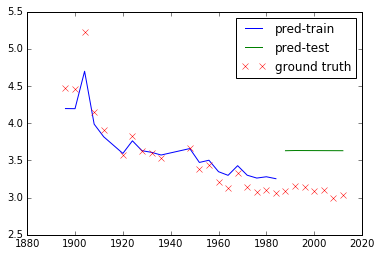

In [4]:
Y_train_pred, Y_train_pred_var = m.predict(X_train)
Y_test_pred, Y_test_pred_var = m.predict(X_test)

plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')

plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')

Not very good, as we expected. Now let's optimise the model parameters. We will do that using the default optimiser and by using Bayesian optmization. We start with this latest option. We first have a look to the parameters we need to tune and we create the domain where the optimisation is going to be carried out.

In [5]:
# Model parameters
m.parameter_names()

['sum.Mat32.variance',
 'sum.Mat32.lengthscale',
 'sum.linear.variances',
 'sum.bias.variance',
 'Gaussian_noise.variance']

In [6]:
# List containing the description of the domain where we will perform the optmisation
domain = [
{'name': 'Mat32.variance',          'type': 'continuous', 'domain': (1,4.)},
{'name': 'Mat32.lengthscale',       'type': 'continuous', 'domain': (50.,150.)},
{'name': 'Linear.variances',        'type': 'continuous', 'domain': (1e-5,6)},
{'name': 'Bias.variance',           'type': 'continuous', 'domain': (1e-5,6)},
{'name': 'Gaussian_noise.variance', 'type': 'continuous', 'domain': (1e-5,4.)}
]

We will minimize the minus marinal log-likelihood. We wrapp it to create our objetive function.

In [7]:
def f_lik(x):
    m[:] = x
    return m.objective_function()

Now create the GPyOpt object and run the optimization procedure. We will use the expected improvement integrated over the GP hyperparameters (so the black hole created is not so dangerous). 

In [8]:
opt = GPyOpt.methods.BayesianOptimization(f = f_lik,                  
                                          domain = domain,
                                          normalize_Y= True,
                                          exact_feval = True,
                                          model_type= 'GP',
                                          acquisition_type ='EI',       
                                          acquisition_jitter = 0.25)   

And we run the optimization for 50 iterations.

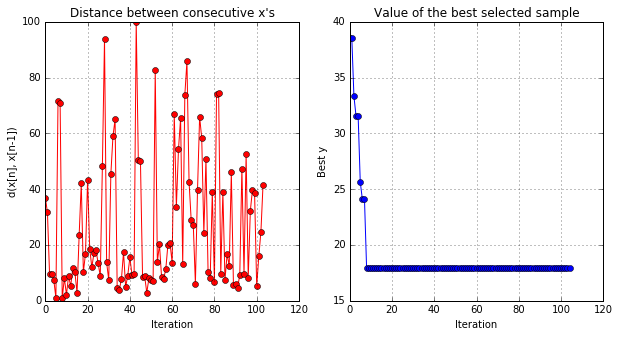

In [9]:
# it may take a few seconds
opt.run_optimization(max_iter=100)
opt.plot_convergence()

Let's show the best parameters found. They differ significantly from the default parameters.

In [10]:
x_best = opt.X[np.argmin(opt.Y)].copy()
m[:] = x_best
print("The best model optimized with GPyOpt:")
print m

The best model optimized with GPyOpt:

Name : GP regression
Objective : 17.9267046505
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  sum.Mat32.variance       |             1.0  |      +ve      |        
  sum.Mat32.lengthscale    |   120.647374996  |      +ve      |        
  sum.linear.variances     |           1e-05  |      +ve      |        
  sum.bias.variance        |             6.0  |      +ve      |        
  Gaussian_noise.variance  |  0.455483640412  |      +ve      |        


And we print the model for the training and testing datasets.

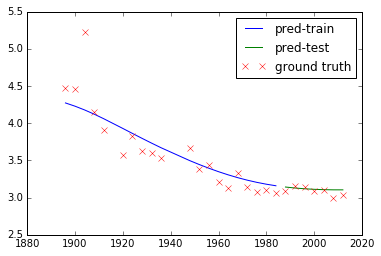

In [11]:
Y_train_pred, Y_train_pred_var = m.predict(X_train)
Y_test_pred, Y_test_pred_var = m.predict(X_test)

plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')

plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')

Now we optimize the model using the default GPy optimizer. To do this we first restrict the search of the parameters the same way we did for the Bayesian optimisation case.

In [12]:
m[:] = opt.X[0].copy()

m.kern.Mat32.variance.constrain_bounded(1,4.)
m.kern.Mat32.lengthscale.constrain_bounded(50,150.)
m.kern.linear.variances.constrain_bounded(1e-5,6)
m.kern.bias.variance.constrain_bounded(1e-5,6)
m.Gaussian_noise.variance.constrain_bounded(1e-5,4.)

In [13]:
m.kern

sum.,value,constraints,priors
Mat32.variance,3.78884827845,"1.0,4.0",
Mat32.lengthscale,109.554470298,"50.0,150.0",
linear.variances,4.48629137848,"1e-05,6.0",
bias.variance,3.93847053438,"1e-05,6.0",


In [14]:
m.optimize()

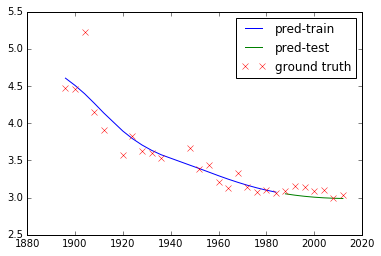

In [15]:
Y_train_pred, Y_train_pred_var = m.predict(X_train)
Y_test_pred, Y_test_pred_var = m.predict(X_test)

plot(X_train,Y_train_pred,'b',label='pred-train')
plot(X_test,Y_test_pred,'g',label='pred-test')

plot(X_train,Y_train,'rx',label='ground truth')
plot(X_test,Y_test,'rx')
legend(loc='best')

In [16]:
print("The best model optimized with the default optimizer:")
print m

The best model optimized with the default optimizer:

Name : GP regression
Objective : 8.41226873402
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  sum.Mat32.variance       |      3.34248386835  |    1.0,4.0    |        
  sum.Mat32.lengthscale    |              150.0  |  50.0,150.0   |        
  sum.linear.variances     |              1e-05  |   1e-05,6.0   |        
  sum.bias.variance        |  1.17204023942e-05  |   1e-05,6.0   |        
  Gaussian_noise.variance  |     0.061131817332  |   1e-05,4.0   |        
